## Oaktree Assesment
### Alex Popat

## Imports

In [274]:
import requests
import pandas as pd
import numpy as np
import os
from fredapi import Fred
import matplotlib.pyplot as plt
import seaborn as sns

## Part 1

## Constants

In [275]:
API_KEY = "f54dfd13cae23848c742d8cc02ee1a16"
START_DATE = "2023-01-01"
END_DATE = "2023-12-31"
SERIES_ID = ["DGS1MO", "DGS3MO", "DGS6MO", "DGS1", "DGS2", "DGS3", "DGS5", "DGS7", "DGS10", "DGS20", "DGS30"]

## Data Pull

In [276]:
def fetch_fred_yield(series_id: list, api_key: str, start_date: str, end_date: str) -> pd.DataFrame:
    # initilize api conncection and df
    fred = Fred(api_key=api_key)
    data = pd.DataFrame()
    
    # fetch data for each tenor
    for id in series_id:
        series_data = fred.get_series(id, observation_start=start_date, observation_end=end_date)
        data[id] = series_data
    
    # set index as datetime
    data.index = pd.to_datetime(data.index)
    
    # forward fill NaN values and drop any remaining i.e. first row
    data.ffill(inplace=True)
    data.dropna(inplace=True)

    # print length of df
    print(f"Data rows: {len(data)}")
    return data

In [277]:
t_data = fetch_fred_yield(SERIES_ID, API_KEY, START_DATE, END_DATE)
t_data.head()

Data rows: 259


,DGS1MO,DGS3MO,DGS6MO,DGS1,DGS2,DGS3,DGS5,DGS7,DGS10,DGS20,DGS30
2023-01-03,4.17,4.53,4.77,4.72,4.40,4.18,3.94,3.89,3.79,4.06,3.88
2023-01-04,4.20,4.55,4.77,4.71,4.36,4.11,3.85,3.79,3.69,3.97,3.81
2023-01-05,4.30,4.66,4.81,4.78,4.45,4.18,3.90,3.82,3.71,3.96,3.78
2023-01-06,4.32,4.67,4.79,4.71,4.24,3.96,3.69,3.63,3.55,3.84,3.67
2023-01-09,4.37,4.70,4.83,4.69,4.19,3.93,3.66,3.60,3.53,3.83,3.66


In [278]:
bond_yields = pd.read_excel("data/Part 1. bonds_yields.xlsx")
bond_yields.head()

,Bond ID,WAL (years),Yield (%),Sector
0,Bond A,1.0,8.63,Telecommunication
1,Bond B,1.5,7.95,Consumer Staples
2,Bond C,2.2,7.53,Utilities
3,Bond D,3.0,7.71,Financials
4,Bond E,4.0,8.45,Telecommunication


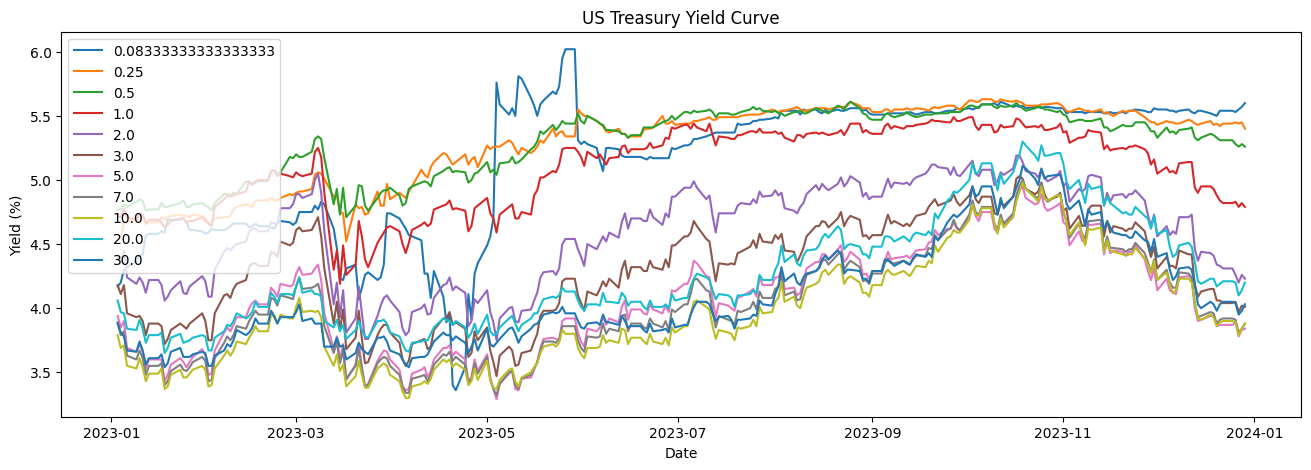

In [289]:
plt.figure(figsize=(16, 5))
plt.plot(t_data, label=t_data.columns)
plt.title("US Treasury Yield Curve")
plt.xlabel("Date")
plt.ylabel("Yield (%)")
plt.legend(t_data.columns)

## Spread Calculation

In [280]:
def calculate_bond_spread(bond_yields: pd.DataFrame, t_data: pd.DataFrame) -> pd.DataFrame:

    # initialize df
    t_spread = pd.DataFrame(index=t_data.index)
    
    # map tenor to column name
    tenor_map = {"DGS1MO": 1/12, "DGS3MO": 3/12, "DGS6MO": 6/12, 
                 "DGS1": 1, "DGS2": 2, "DGS3": 3, "DGS5": 5, "DGS7": 7, "DGS10": 10, "DGS20": 20, "DGS30": 30}
    
    t_data.columns = [tenor_map[col] for col in t_data.columns]
    
    # iterate over each bond
    for idx, row in bond_yields.iterrows():
        
        WAL = row["WAL (years)"]
        yld = row["Yield (%)"]
        
        # check if WAL is out of range
        if WAL < min(t_data.columns) or WAL > max(t_data.columns):
            print(f"WAL out of range for bond {row['Bond ID']}")
            continue

        # exact match
        elif WAL in t_data.columns:
            spread = yld - t_data[WAL]

        # interpolate
        else:
            low_tenor = max([col for col in t_data.columns if col < WAL])
            high_tenor = min([col for col in t_data.columns if col > WAL])
            interp_ret = t_data[low_tenor] + ((WAL - low_tenor) / (high_tenor - low_tenor)) * (t_data[high_tenor] - t_data[low_tenor])
            spread = yld - interp_ret
        
        t_spread[row['Bond ID']] = spread

    return t_spread

In [281]:
bond_t_curve_spread_df = calculate_bond_spread(bond_yields, t_data)
bond_t_curve_spread_df.head()

,Bond A,Bond B,Bond C,Bond D,Bond E,Bond F,Bond G,Bond H,Bond I,Bond J,...,Bond M,Bond N,Bond O,Bond P,Bond Q,Bond R,Bond S,Bond T,Bond U,Bond V
2023-01-03,3.91,3.390,3.174,3.53,4.390,3.80,3.750,4.173333,4.506667,3.3800,...,3.386,3.6300,4.7075,3.645,3.956667,4.390,4.405,2.920,3.635,3.766667
2023-01-04,3.92,3.415,3.220,3.60,4.470,3.89,3.846,4.273333,4.606667,3.4650,...,3.450,3.7050,4.7990,3.740,4.056667,4.490,4.496,2.975,3.734,3.866667
2023-01-05,3.85,3.335,3.134,3.53,4.410,3.84,3.808,4.246667,4.583333,3.4100,...,3.376,3.6400,4.7520,3.700,4.028333,4.465,4.448,2.895,3.702,3.839333
2023-01-06,3.92,3.475,3.346,3.75,4.625,4.05,4.006,4.426667,4.753333,3.6225,...,3.594,3.8575,4.9590,3.900,4.213333,4.640,4.656,3.110,3.894,4.021333
2023-01-09,3.94,3.510,3.392,3.78,4.655,4.08,4.036,4.453333,4.776667,3.6525,...,3.628,3.8875,4.9890,3.930,4.241667,4.665,4.686,3.150,3.924,4.048667


## Visualizations

### Spread Box Plot

In [282]:
def create_box_plot(spread_df, bond_df, title):
    fig, ax = plt.subplots(figsize=(20, 6))
    ax.boxplot(spread_df)
    ax.set_xticklabels(bond_yields['Sector'], rotation=45)
    ax.set_title(title)
    ax.set_ylabel("Spread (%)")
    ax.set_xlabel("Bond ID")
    plt.show()

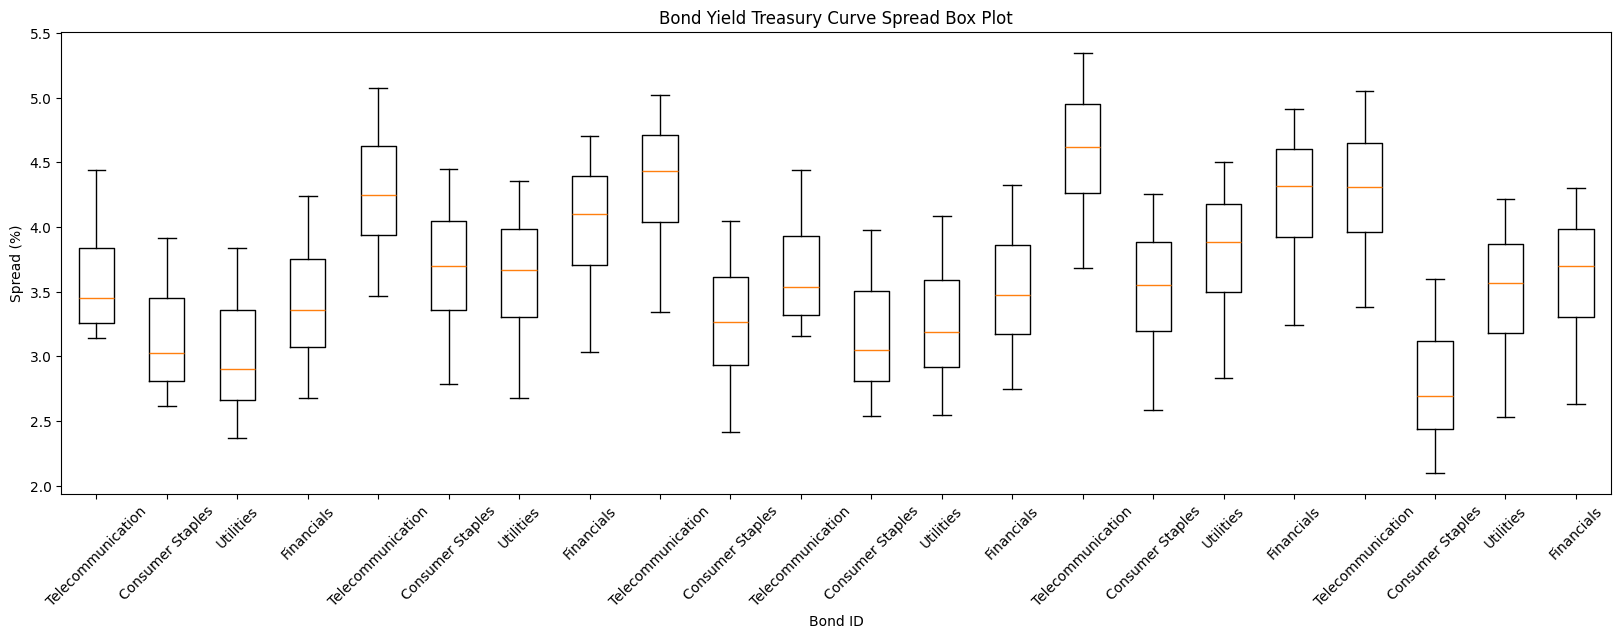

In [283]:
create_box_plot(bond_t_curve_spread_df, bond_yields, "Bond Yield Treasury Curve Spread Box Plot")

### Spread Correlation Heatmap

In [284]:
def create_corr_heatmap(spread_df, bond_df, title):
    fig, ax = plt.subplots(figsize=(12, 8))
    corr_matrix = spread_df.corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', xticklabels=bond_df['Sector'], yticklabels=bond_df['Sector'])
    plt.xticks(rotation=45, ha="right", fontsize=10)
    ax.set_title(title)
    plt.show()

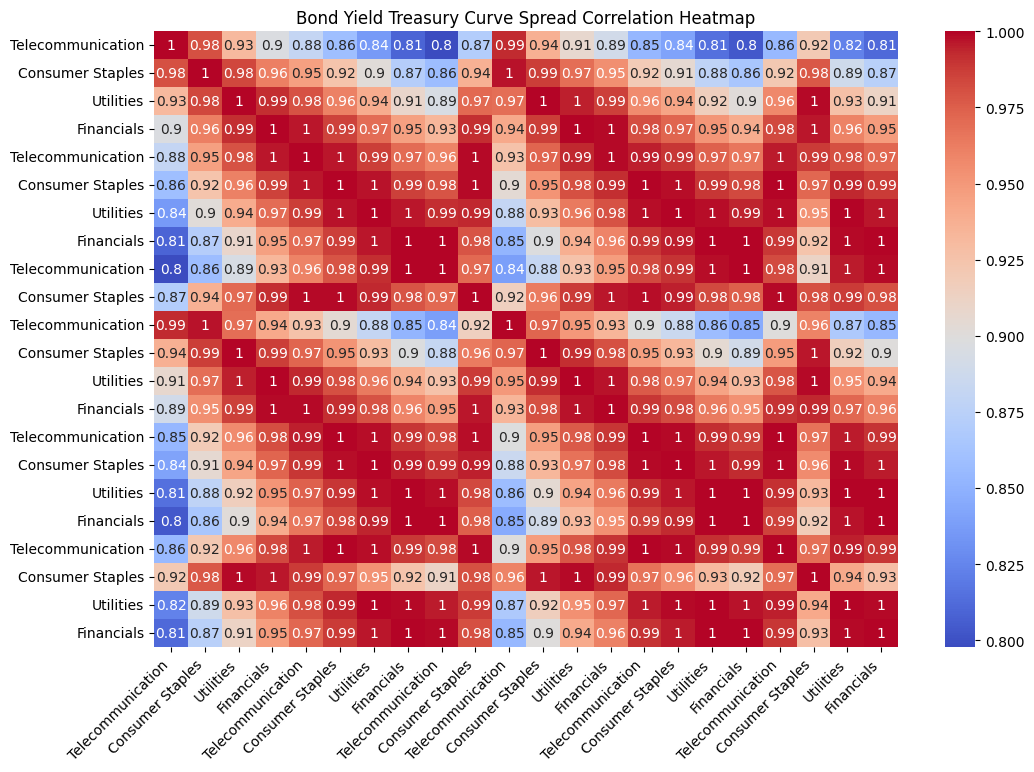

In [285]:
create_corr_heatmap(bond_t_curve_spread_df, bond_yields, "Bond Yield Treasury Curve Spread Correlation Heatmap")

### Spread Summary Statistics

In [286]:
bond_t_curve_spread_df.describe()

,Bond A,Bond B,Bond C,Bond D,Bond E,Bond F,Bond G,Bond H,Bond I,Bond J,...,Bond M,Bond N,Bond O,Bond P,Bond Q,Bond R,Bond S,Bond T,Bond U,Bond V
count,259.000000,259.000000,259.000000,259.000000,259.000000,259.00000,259.000000,259.000000,259.000000,259.000000,...,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000
mean,3.545405,3.114479,3.000131,3.406448,4.268089,3.67973,3.619490,4.024942,4.347220,3.258909,...,3.249869,3.507268,4.584670,3.516197,3.813803,4.236081,4.283023,2.765000,3.499371,3.620486
std,0.320256,0.350068,0.390768,0.394047,0.399308,0.40758,0.416824,0.424578,0.425453,0.403078,...,0.392606,0.396293,0.409652,0.415109,0.424385,0.424934,0.408943,0.391218,0.422375,0.424481
min,3.140000,2.615000,2.372000,2.680000,3.470000,2.79000,2.680000,3.036667,3.343333,2.415000,...,2.548000,2.747500,3.682500,2.585000,2.833333,3.240000,3.385000,2.100000,2.535000,2.635333
25%,3.260000,2.807500,2.666000,3.070000,3.940000,3.36000,3.301000,3.708333,4.040000,2.931250,...,2.919000,3.176250,4.265250,3.197500,3.494167,3.922500,3.963500,2.435000,3.177500,3.302667
50%,3.450000,3.025000,2.906000,3.360000,4.250000,3.70000,3.666000,4.100000,4.430000,3.262500,...,3.190000,3.477500,4.615000,3.555000,3.881667,4.315000,4.310000,2.690000,3.563000,3.694667
75%,3.840000,3.452500,3.355000,3.750000,4.622500,4.04500,3.983000,4.393333,4.713333,3.616250,...,3.593000,3.858750,4.949500,3.880000,4.179167,4.605000,4.648000,3.120000,3.865500,3.987667
max,4.440000,3.915000,3.836000,4.240000,5.070000,4.45000,4.352000,4.703333,5.016667,4.045000,...,4.084000,4.325000,5.345500,4.255000,4.501667,4.910000,5.047000,3.600000,4.213000,4.300667


### Spread time-series

In [290]:
def create_time_series_plot(spread_df, bond_df, title):
    fig, ax = plt.subplots(figsize=(20, 6))
    ax.plot(spread_df)
    ax.set_title(title)
    ax.set_ylabel("Spread (%)")
    ax.set_xlabel("Date")
    ax.legend(bond_df['Sector'])
    plt.show()

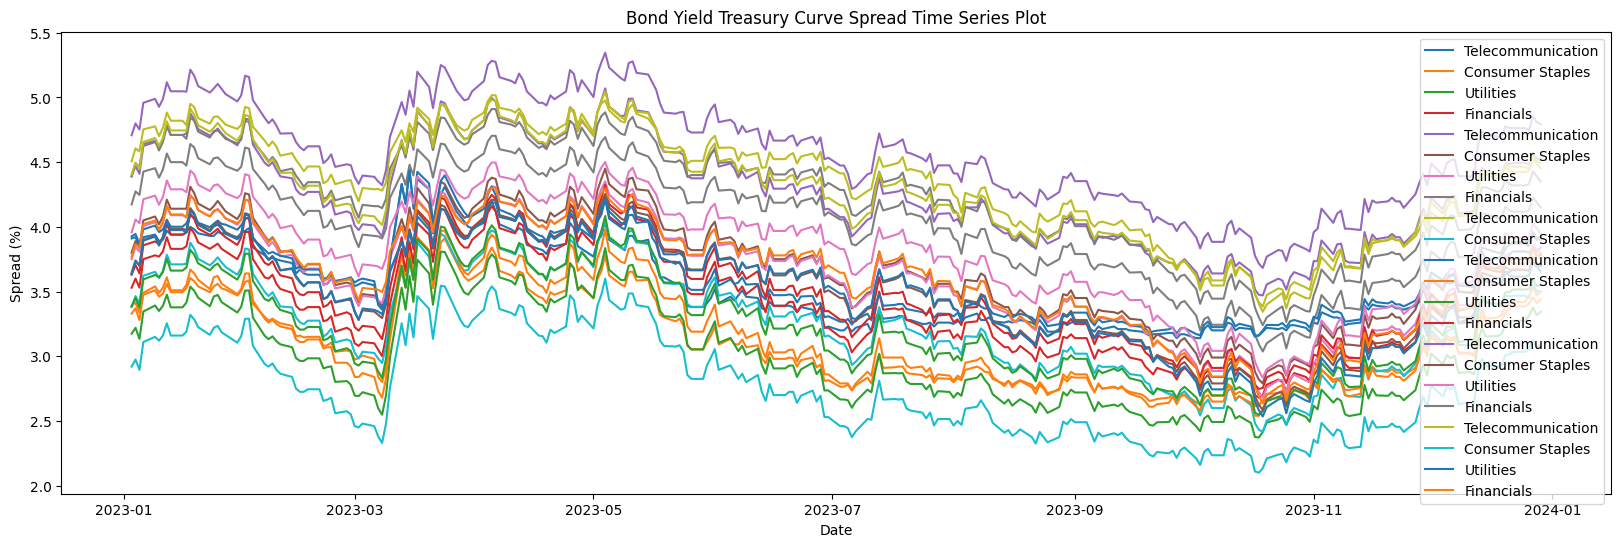

In [291]:
create_time_series_plot(bond_t_curve_spread_df, bond_yields, "Bond Yield Treasury Curve Spread Time Series Plot")

With the addition of time I would:
1. Conduct additional analysis of spread returns e.g. would analyzing correlation between bond spreads help create a diversified portfolio
2. Look at relative value compared to other data sources on the sectors such as sector indices, other assets in those sectors, etc.
3. Determine more vizualizations and statistics to showcase e.g. ACF, PACF, fitting ARIMA and GARCH models to the time-series returns, etc.
4. Look at higher moments e.g. skew, kurtosis
5. Implement a more sophisticated stochastic interolation model

## Part 2

### Imports

In [392]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

### Load Data

In [304]:
loan_data = pd.read_csv("data/Part 2. loan_data_final.csv", index_col=0)
loan_data.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_to_income_ratio,loan_type,dependents_count,regional_unemployment_rate,borrower_risk_score,loan_status
0,22,female,Master,71948,0,RENT,PERSONAL,16.02,0.49,3,561,No,0.49,FLOATING,3,6.84,281.4,1
1,21,female,High School,12282,0,OWN,EDUCATION,11.14,0.08,2,504,Yes,0.08,FIXED,0,5.96,252.4,0
2,25,female,High School,12438,3,MORTGAGE,MEDICAL,12.87,0.44,3,635,No,0.44,FIXED,0,6.69,318.4,1
3,23,female,Bachelor,79753,0,RENT,MEDICAL,15.23,0.44,2,675,No,0.44,FIXED,3,7.63,338.1,1
4,24,male,Master,66135,1,RENT,MEDICAL,14.27,0.53,4,586,No,0.53,FLOATING,0,4.63,294.2,1


In [310]:
# no missing values
loan_data[loan_data.isna().any(axis=1)]

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_to_income_ratio,loan_type,dependents_count,regional_unemployment_rate,borrower_risk_score,loan_status


### Split data into dependent and independent variables

In [ ]:
def create_confusion_matrix(y_test, y_pred):
    fig, ax = plt.subplots(figsize=(12, 5))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, cmap='coolwarm', fmt='d', xticklabels=["No Default", "Default"], yticklabels=["No Default", "Default"])
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_title("Confusion Matrix")

In [389]:
def model_run(data: pd.DataFrame, ML_model):
    
    # split data into train and test
    X = data.drop(columns=["loan_status"])
    y = data["loan_status"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)
    
    # define numeric and categorical features
    numeric_features = X.select_dtypes(include=['number']).columns
    categorical_features = X.select_dtypes(include=[object]).columns

    # scale numeric features and transform categorical features
    numeric_pipeline = Pipeline([('scaler', StandardScaler())])
    categorical_pipeline = Pipeline([('encoder', OneHotEncoder())])

    preprocessor = ColumnTransformer([('numeric', numeric_pipeline, numeric_features), 
                                  ('categorical', categorical_pipeline, categorical_features)])

    # define model
    model = Pipeline([('preprocessor', preprocessor), 
                  ('classifier', ML_model)])
    
    # fit model and predict
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # print classification report and confusion matrix
    class_report = classification_report(y_test, y_pred, zero_division=0, target_names=["No Default", "Default"])
    print(class_report)

    create_confusion_matrix(y_test, y_pred)

### Logistic Regression Classifier

              precision    recall  f1-score   support

  No Default       0.93      0.94      0.94      7011
     Default       0.78      0.75      0.77      1989

    accuracy                           0.90      9000
   macro avg       0.86      0.85      0.85      9000
weighted avg       0.90      0.90      0.90      9000



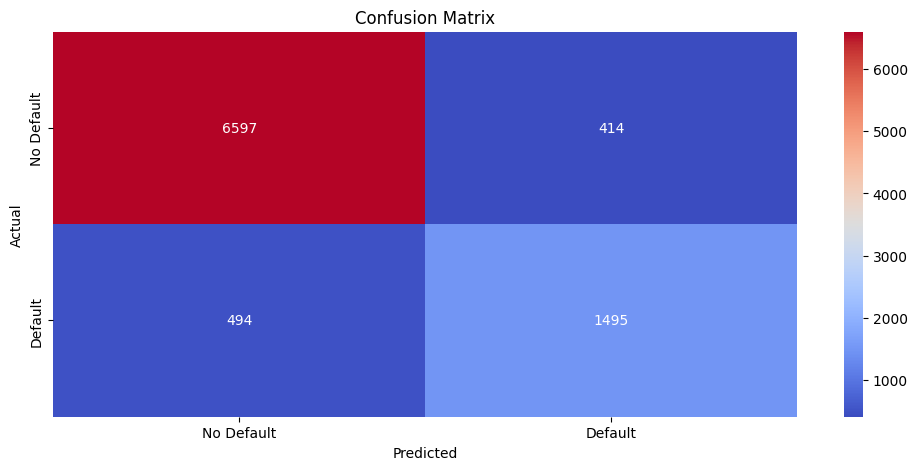

In [391]:
model_run(loan_data, LogisticRegression(max_iter=1000, random_state=99))

### Random Forest Classifier

              precision    recall  f1-score   support

  No Default       0.93      0.97      0.95      7011
     Default       0.89      0.76      0.82      1989

    accuracy                           0.93      9000
   macro avg       0.91      0.87      0.89      9000
weighted avg       0.93      0.93      0.92      9000



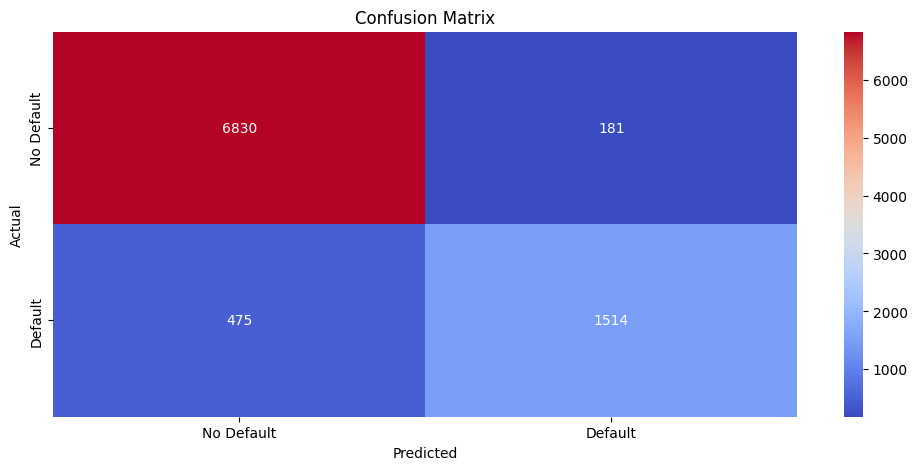

In [393]:
model_run(loan_data, RandomForestClassifier(n_estimators=100, random_state=99))

### Gradient Boosting Classifier


              precision    recall  f1-score   support

  No Default       0.94      0.97      0.95      7011
     Default       0.88      0.77      0.82      1989

    accuracy                           0.93      9000
   macro avg       0.91      0.87      0.89      9000
weighted avg       0.92      0.93      0.92      9000



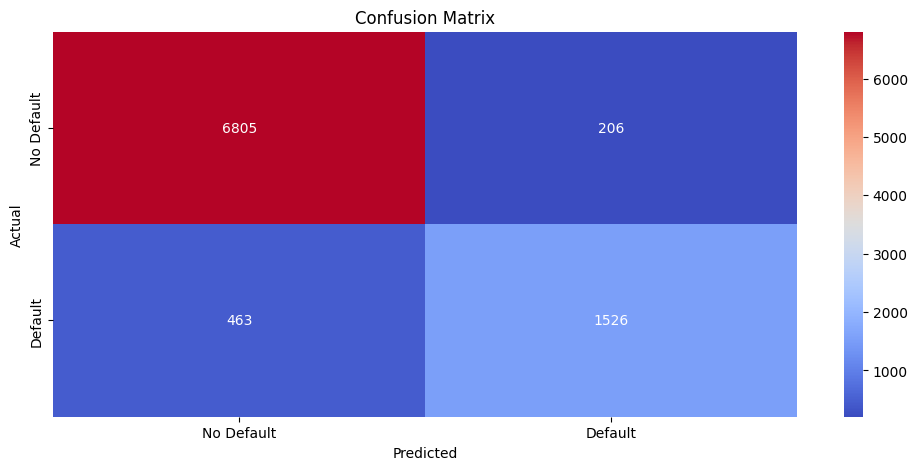

In [394]:
model_run(loan_data, GradientBoostingClassifier(n_estimators=100, random_state=99))

### SVC Classifier


              precision    recall  f1-score   support

  No Default       0.93      0.96      0.95      7011
     Default       0.85      0.74      0.79      1989

    accuracy                           0.91      9000
   macro avg       0.89      0.85      0.87      9000
weighted avg       0.91      0.91      0.91      9000



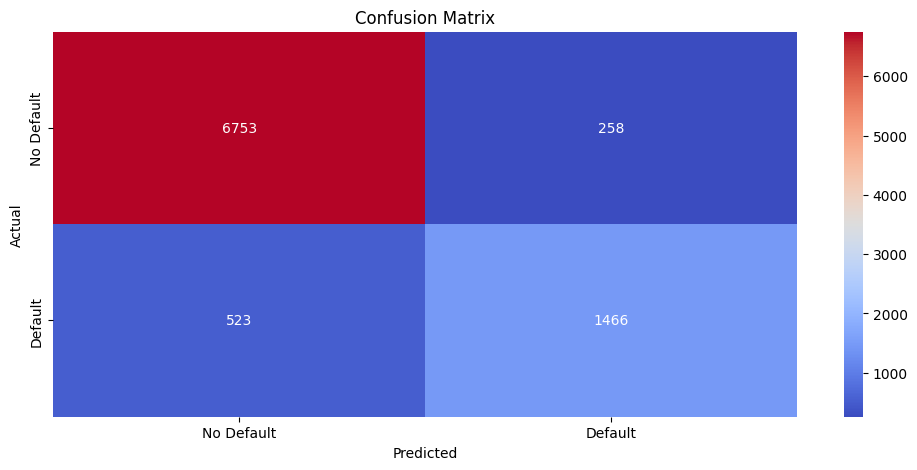

In [395]:
model_run(loan_data, SVC(probability=True, random_state=99))

## Notes

In this part I provided basic implementations of a few machine learning models to predict the default of loans

Models Implemented:
* Logistic regression
* Gradient Boosting
* SVC

With the addition of time I would:
1. Outline the reasoning and mathematics as to why these models are good candidates for the task
2. Implement cross-validation to obtain a better estimate of a model's predictive power
3. Investigate the time-series nature of the data i.e. can the data be shuffled, what horizon is our forecast over, dow we have time-series data for each unique loan
4. Peform a grid search or parameter optimization to tune the models
5. Conudct PCA to transform variables into independent and linear combinations of variables tp perform modeling on this smaller subset of features
6. Reformulate to be object-oriented to consolidate code and make using different modeling aproaches easier
7. Look at the AUC for an ROC curve to determine model effectiveness
7. Analyze reuslts more in-depth (in this part I only got to setup the problem and have a basic working solution)
